In [1]:

%cd ..

/home/prayson/Code/hadithi/dev.io


In [77]:
import pandas as pd
import numpy as np

pd.options.plotting.backend = "plotly"

In [3]:
df = pd.read_csv("assets/bolig.csv.gzip", compression="gzip", parse_dates=["soldDate"])
df.sample(4)

estateId                    address  zipCode     price  \
66425   1060221        Ved Volden 1, 4. th     1425   3250000   
74933         0    P.D. Løvs Allé 6, 3. th     2200  11850000   
57577   1297987  Sundby Parkvej 18, st. tv     2300   4295000   
55669   1361165  Frederikssundsvej 195A, 4     2700   3000000   

                       soldDate  propertyType   saleType    sqmPrice  rooms  \
66425 2015-06-10 22:00:00+00:00             3  Alm. Salg   34946.240    3.0   
74933 2012-12-11 23:00:00+00:00             3  Alm. Salg  162328.770    3.0   
57577 2017-05-30 22:00:00+00:00             3  Alm. Salg   39403.668    3.0   
55669 2017-09-30 22:00:00+00:00             3  Alm. Salg   34883.723    3.0   

       size  ...    change                                  guid   latitude  \
66425    93  ... -1.365706  8E396E3A-BF93-4822-AC27-6128CA7E03EF  55.671380   
74933    73  ...  0.000000  293BF7A5-F261-4D23-8921-AA5B0565DBEB  55.697610   
57577   109  ...  0.000000  966B4DBB-E8DD-46F3-A249-A86B34557FF2  55.662827   
55669    86  ...  0.166945  B22201B8-FC0E-489F-BD01-E0CADBAA1327  55.705120   

       longitude  municipalityCode  estateCode         city groupKey  \
66425  12.593866               101      725715  København K      NaN   
74933  12.551435               101      362418  København N      4.0   
57577  12.630810               101        2289  København S      NaN   
55669  12.493275               101        8259     Brønshøj      NaN   

       canGetVR    bfEnr  
66425      True   114125  
74933      True  6020627  
57577      True   135850  
55669      True   102949  

[4 rows x 21 columns]

In [4]:
df.columns

Index(['estateId', 'address', 'zipCode', 'price', 'soldDate', 'propertyType',
       'saleType', 'sqmPrice', 'rooms', 'size', 'buildYear', 'change', 'guid',
       'latitude', 'longitude', 'municipalityCode', 'estateCode', 'city',
       'groupKey', 'canGetVR', 'bfEnr'],
      dtype='object')

In [115]:
# Sorting fam_salg away
SALES_TYPE = "Alm. Salg"
# Sorting apartments away that where sold for under 500.000 and above 9.000.000
LOWER_PRICE, HIGHER_PRICE = 450_000, 9_500_000

# Sorting apartments away that have above 5 roomes doe to the likelyhood of it being under 0.001%procent
NUMBER_OF_ROOMS = 5

# Number of Days from Max Date
DAYS_FROM_MAX_DATE = 31 + 30 + 31 + 30


alm_salg_df = (
    df.loc[
        (df["saleType"].eq(SALES_TYPE))
        & (df["price"].between(LOWER_PRICE, HIGHER_PRICE))
        & (df["rooms"].le(NUMBER_OF_ROOMS))
    ]
    .assign(
        floor=lambda d: d["address"]
        .str.extract(r",\s*(?P<floor>\d+|st)(?=\s*[a-z]*\.?\s|$)")
        .replace("st", 0)
        .fillna(0)
        .astype(int)
    )
    .assign(
        days_from_latest=lambda d: (d["soldDate"].max() - d["soldDate"]).dt.days
    )
    .sort_values(by="soldDate")
    .loc[lambda d: d["days_from_latest"] <= DAYS_FROM_MAX_DATE ]
)

(alm_salg_df
  .sample(5)
  .loc[:, ["price", "rooms", "size", "soldDate"]]
  .assign(soldAge = lambda d: (d["soldDate"].dt.date - pd.to_datetime("1991-01-01")).dt.days/365)
  .loc[:,["price", "rooms", "size", "soldAge"]] 
)

In [95]:
alm_salg_df.columns

Index(['estateId', 'address', 'zipCode', 'price', 'soldDate', 'propertyType',
       'saleType', 'sqmPrice', 'rooms', 'size', 'buildYear', 'change', 'guid',
       'latitude', 'longitude', 'municipalityCode', 'estateCode', 'city',
       'groupKey', 'canGetVR', 'bfEnr', 'floor'],
      dtype='object')

In [96]:
from pathlib import Path
import plotly.express as px

px.set_mapbox_access_token(Path(".mapbox_token").read_text())

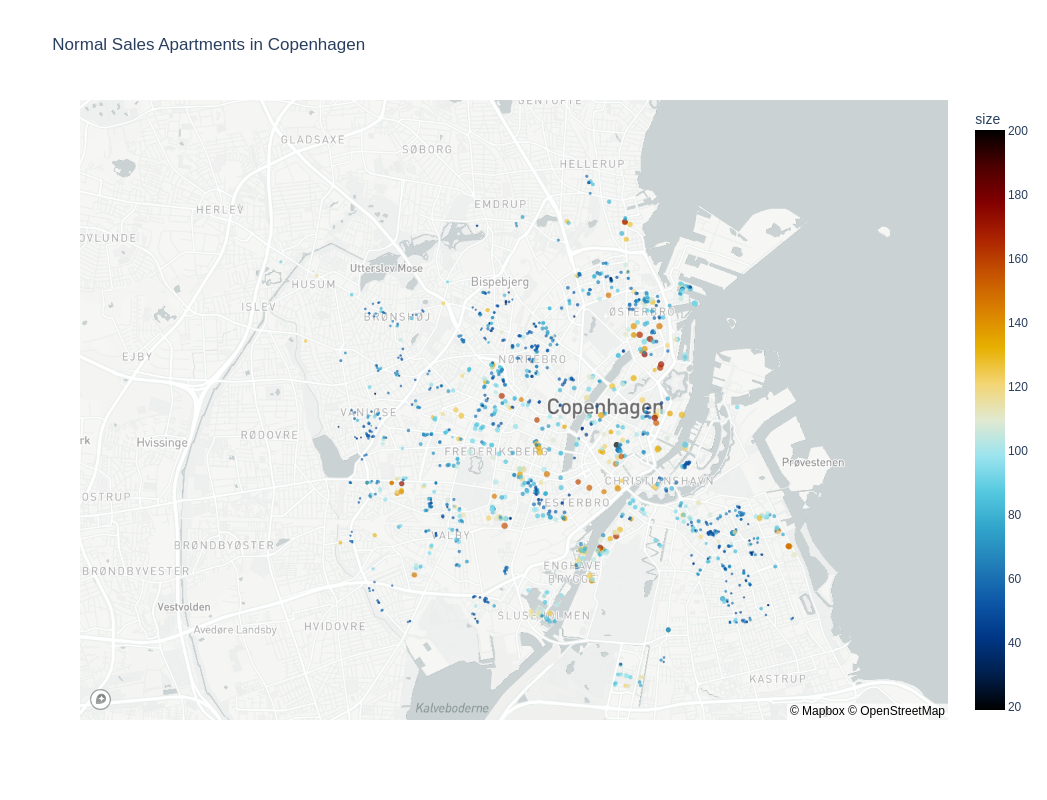

In [97]:
px.scatter_mapbox(
    alm_salg_df,
    lat="latitude",
    lon="longitude",
    color="size",
    size="price",
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=5,
    zoom=11,
    title="Normal Sales Apartments in Copenhagen",
    hover_name="address",
    hover_data=["rooms", "buildYear", "floor"],
    center=dict(
        lat=55.6861,
        lon=12.5388,
    ),
    width=1200,
    height=800,
)

In [98]:
features = [
    "address",
    "zipCode",
    "soldDate",
    "rooms",
    "floor",
    "size",
    "buildYear",
    "latitude",
    "longitude",
    "municipalityCode",
    "estateCode",
    "city",
    "price",
]



In [99]:
explore_data = alm_salg_df[features].astype(
    {
        "rooms": np.int8,
        "size": np.int16,
        "buildYear": np.int32,
        "municipalityCode": np.int32,
        "estateCode": np.int32,
        "zipCode": np.int32,
    }
)
explore_data = (
    explore_data.assign(
        soldYear=lambda d: d["soldDate"].dt.year,
        soldMonth=lambda d: d["soldDate"].dt.month,
    ).drop(columns=["address", "soldDate"])

)

In [100]:
order_columns = [
    "price",
    "size",
    "rooms",
    "floor",
    "longitude",
    "latitude",
    "buildYear",
    "soldMonth",
    "soldYear",
    "zipCode",
    "city",
]

## Middle Age Tools

In [101]:
import hiplot as hip

In [102]:
explore_data.columns[::-1]

Index(['soldMonth', 'soldYear', 'price', 'city', 'estateCode',
       'municipalityCode', 'longitude', 'latitude', 'buildYear', 'size',
       'floor', 'rooms', 'zipCode'],
      dtype='object')

In [103]:
viz = hip.Experiment.from_dataframe(explore_data[order_columns])

In [104]:
viz.display();  # soldMonth has no effect & interestubg suze of 857, I think the correct is 85.7

<IPython.core.display.Javascript object>

In [17]:
explore_data = (
    explore_data
    #.drop(columns=["address", "soldDate"])
    # after the viz, we discovered Build Year 0 and size 857?
    .loc[lambda d: (d['buildYear'].ne(0))]
)

In [18]:
alm_salg_df_filtered = pd.merge(
    alm_salg_df[["address", "soldDate"]],
    explore_data,
    how="inner",
    left_index=True,
    right_index=True,
)

In [19]:
# alm_salg_df_filtered.loc[lambda d: d["floor"].gt(24)]

In [20]:
alm_salg_df_filtered

address                  soldDate  zipCode  \
18164           Dagmarsgade 28, 1. 70 2023-06-21 22:00:00+00:00     2200   
18163          Flensborggade 5, 1. tv 2023-06-21 22:00:00+00:00     1669   
18162        Offenbachsvej 27, st. tv 2023-06-21 22:00:00+00:00     2450   
18161           Klintholmvej 2, 3. tv 2023-06-21 22:00:00+00:00     2700   
18159  Andrei Sakharovs Vej 21, 3. tv 2023-06-21 22:00:00+00:00     2450   
...                               ...                       ...      ...   
17259             Trekronergade 68, 1 2023-09-20 22:00:00+00:00     2500   
17257            Strandlodsvej 19C, 7 2023-09-21 22:00:00+00:00     2300   
17256         Klaksvigsgade 12, 1. th 2023-09-21 22:00:00+00:00     2300   
17254         Holmbladsgade 58, 3. th 2023-09-21 22:00:00+00:00     2300   
17255           Rundholtsvej 7, 1. tv 2023-09-21 22:00:00+00:00     2300   

       rooms  floor  size  buildYear   latitude  longitude  municipalityCode  \
18164      1      1    56       1974  55.698270  12.546600               101   
18163      2      1    52       1897  55.668762  12.547255               101   
18162      2      0    51       1936  55.648975  12.529540               101   
18161      2      3    49       1935  55.704865  12.494356               101   
18159      4      3   112       2020  55.656216  12.560399               101   
...      ...    ...   ...        ...        ...        ...               ...   
17259      3      1    75       1914  55.655933  12.519941               101   
17257      5      7   128       2017  55.665154  12.623071               101   
17256      2      1    93       2006  55.667297  12.580413               101   
17254      3      3    77       1903  55.665596  12.609646               101   
17255      4      1    98       2019  55.653294  12.565753               101   

       estateCode          city    price  soldYear  soldMonth  
18164      743683   København N  2565000      2023          6  
18163      143295   København V  2250000      2023          6  
18162      415228  København SV  2305000      2023          6  
18161      306496      Brønshøj  1775000      2023          6  
18159       39640  København SV  7100000      2023          6  
...           ...           ...      ...       ...        ...  
17259      792463         Valby  3600000      2023          9  
17257       24984   København S  7800000      2023          9  
17256        1078   København S  4725000      2023          9  
17254      233774   København S  3490000      2023          9  
17255       33516   København S  6000000      2023          9  

[805 rows x 15 columns]

In [21]:
interesting_columns = [
    "price",
    "size",
    "rooms",
    "floor",
    "longitude",
    "latitude",
    "buildYear",
    "soldYear",
    "zipCode",
    "city",
]

In [22]:
from sklearn.model_selection import train_test_split

In [35]:
X = explore_data[
    [
        "size",
        "rooms",
        "longitude",
        "latitude",
        "buildYear",
        "floor",
        "soldYear",
        "zipCode",
        "city",
    ]
]
y = explore_data["price"]

In [36]:
train_data = X.assign(price=y)

In [37]:
train_data.columns

Index(['size', 'rooms', 'longitude', 'latitude', 'buildYear', 'floor',
       'soldYear', 'zipCode', 'city', 'price'],
      dtype='object')

In [38]:
from sklearn.linear_model import LinearRegression
import patsy as ps

In [ ]:
train_data.sample(2)

In [56]:
# price ~ size

formula = (
    "price ~ size + C(rooms) + C(buildYear) + latitude + longitude - 1"
)

In [58]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter(action="ignore", category=FutureWarning)

    y_, X_ = ps.dmatrices(formula, data=train_data)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X_, y_, train_size=0.9, random_state=42
)
y_train, y_test = y_train.ravel(), y_test.ravel()

In [61]:
LinearRegression(n_jobs=-1).fit(X_train, y_train).score(X_test, y_test)

-4.246081081727657e+18

In [62]:
from sklearn.neighbors import KNeighborsRegressor

In [63]:
KNeighborsRegressor(n_jobs=-1, n_neighbors=7).fit(X_train, y_train).score(
    X_test, y_test
)

0.6517072330057394

In [80]:
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor

In [81]:
GradientBoostingRegressor(
    learning_rate=0.7,
    n_estimators=107,
).fit(
    X_train, y_train
).score(X_test, y_test)

0.83636428706094

In [83]:
ExtraTreesRegressor(n_jobs=-1, n_estimators=107).fit(X_train, y_train).score(
    X_test, y_test
)

0.8352666353403735

In [45]:
# AutoML can do way better parameters searching?

In [85]:
from flaml import AutoML

In [86]:
automl = AutoML()

automl_settings = {
    "time_budget": 60 * 7,  # in seconds
    "metric": "rmse",
    "task": "regression",
    "log_file_name": "bolig.log",
    "estimator_list": [
        "xgboost",
        "xgb_limitdepth",
        "lgbm",
        "catboost",
        "extra_tree",
    ],
    "sample": True,
    "n_jobs": -1,
}
X_.design_info.column_names
automl.fit(X_train=X_train, y_train=y_train, **automl_settings)

[flaml.automl.logger: 12-14 10:34:36] {1679} INFO - task = regression
[flaml.automl.logger: 12-14 10:34:36] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 12-14 10:34:36] {1788} INFO - Minimizing error metric: rmse
[flaml.automl.logger: 12-14 10:34:36] {1900} INFO - List of ML learners in AutoML Run: ['xgboost', 'xgb_limitdepth', 'lgbm', 'catboost', 'extra_tree']
[flaml.automl.logger: 12-14 10:34:36] {2218} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 12-14 10:34:37] {2344} INFO - Estimated sufficient time budget=835s. Estimated necessary time budget=4s.
[flaml.automl.logger: 12-14 10:34:37] {2391} INFO -  at 0.1s,	estimator xgboost's best error=2948910.9490,	best estimator xgboost's best error=2948910.9490
[flaml.automl.logger: 12-14 10:34:37] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 12-14 10:34:37] {2391} INFO -  at 0.1s,	estimator lgbm's best error=1505864.2132,	best estimator lgbm's best error=1505864.2132
[flaml.automl.l

In [88]:
automl.score(X_test, y_test)

0.89546745674374

In [89]:
automl.best_estimator, automl.best_config_per_estimator.get(automl.best_estimator)

('catboost',
 {'early_stopping_rounds': 15,
  'learning_rate': 0.06612468064067507,
  'n_estimators': 175})

## End yet another

In [81]:

from sklearn.metrics import mean_squared_error, r2_score

In [91]:
%%time
y_pred = automl.predict(X_test).round(0).astype(int)
mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)

CPU times: user 25.6 ms, sys: 0 ns, total: 25.6 ms
Wall time: 20.7 ms


671181.7625850709

In [ ]:
# automlx is slow in scoring

In [68]:
import pickle

In [69]:
Path("notebooks/models/automlII.pkl").write_bytes(
    pickle.dumps(automl, pickle.HIGHEST_PROTOCOL)
)

NameError: name 'automl' is not defined

In [70]:
predictor = pickle.loads(Path("notebooks/models/automlII.pkl").read_bytes()).model

In [71]:
predicted_price = predictor.predict(X_test).round(0).astype(int)

In [72]:
def restore_category(df, name):
    return (
        df[df.columns[df.columns.str.startswith(f"C({name})")]]
        .idxmax(axis=1)
        .str.extract(f"\[\.|(?P<{name}>\d+)\]")
        .astype(int)
    )

In [75]:
p = (
    pd.DataFrame(X_test, columns=X_.design_info.column_names)
    .assign(
        rooms=lambda d: restore_category(d, name="rooms"),
        buildYear=lambda d: restore_category(d, name="buildYear"),
        #soldYear=lambda d: restore_category(d, name="soldYear"),
        actual_price=y_test,
        predicted_price=predicted_price,
        residual=lambda d: d["predicted_price"] - d["actual_price"],
        under_estimate=lambda d: d["residual"] < 0,
    )
    # .sort_values(by=["actual_price", "predicted_price"]
    .loc[:, lambda d: d.columns[~d.columns.str.startswith("C(")]]
    .reset_index(drop=True)
)

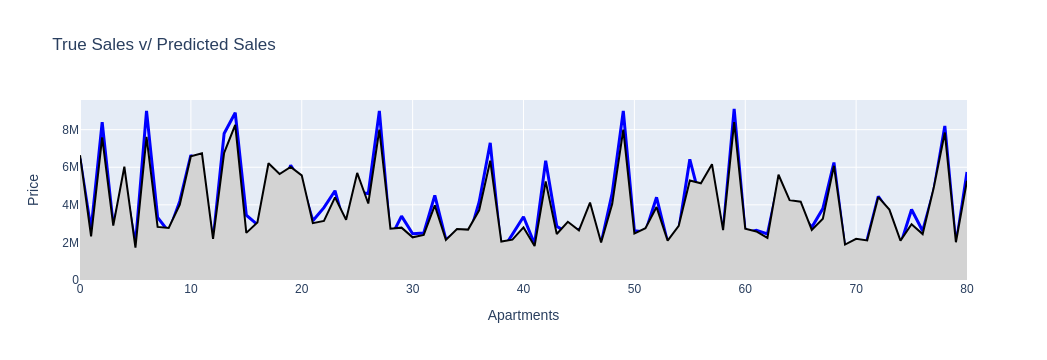

In [78]:
(
    p.plot(
        kind="line",
        y="actual_price",
        title=f"True Sales v/ Predicted Sales",
    )
    .update_traces(line=dict(color="blue", width=3))
    .update_layout(
        hovermode="x unified",
        xaxis_title="Apartments",
        yaxis_title="Price",
    )
    # .add_traces(p.plot(kind="line", y="predicted_price")
    #            .update_traces(line = dict(color = 'black', width=2)
    #                                                                  ).data
    #           )
    .add_traces(
        p.plot(kind="area", y="predicted_price")
        .update_traces(
            line=dict(color="black", width=2),
            fill="tonexty",
            fillcolor="lightgrey",
        )
        .data
    )
)

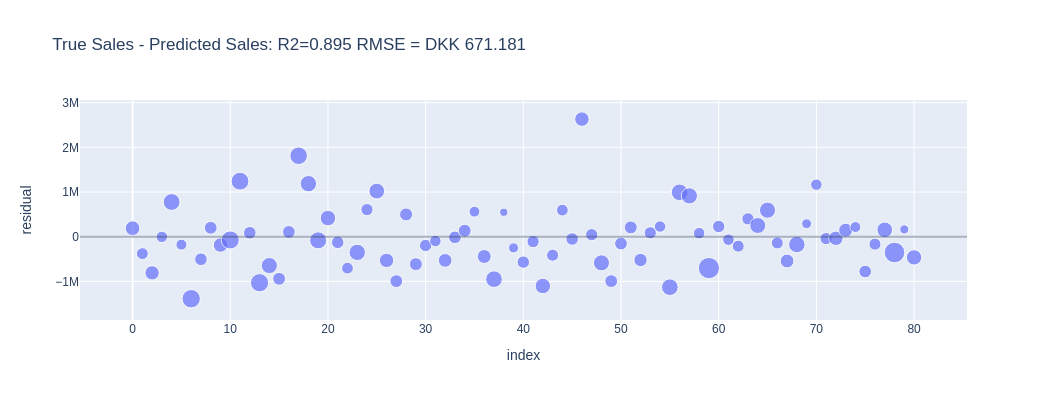

In [82]:
fig_size = {"width": 1200, "height": 400}
R2 = predictor.score(X_test, y_test).round(3)
RMSE = f"{int(mean_squared_error(y_true=y_test, y_pred=predicted_price, squared=False)):,}".replace(
    ",", "."
)

(
    p.plot(
        kind="scatter",
        y="residual",
        x=p.index,
        size="size",
        size_max=15,
        title=f"True Sales - Predicted Sales: {R2=} RMSE = DKK {RMSE}",
        **fig_size,
    )
    .add_hline(
        y=0,
        opacity=0.4,
    )
    .update_traces(mode="markers")
    .update_layout(hovermode="y")
)

In [83]:
# worst 5
p.assign(residual=lambda d: abs(d["residual"])).sort_values("residual").reset_index(
    drop=True
).iloc[-5:]

size   latitude  longitude  rooms  buildYear  actual_price  \
76  103.0  55.689526  12.532521      3       1902     4450000.0   
77  122.0  55.679054  12.569960      3       1799     5500000.0   
78  130.0  55.678470  12.588093      4       1872     9000000.0   
79  119.0  55.692700  12.521000      5       1969     4400000.0   
80   81.0  55.680832  12.517647      2       1885     1487500.0   

    predicted_price   residual  under_estimate  
76          5637592  1187592.0           False  
77          6743633  1243633.0           False  
78          7612865  1387135.0            True  
79          6212983  1812983.0           False  
80          4120577  2633077.0           False

In [84]:
# best 5
p.assign(residual=lambda d: abs(d["residual"])).sort_values("residual").reset_index(
    drop=True
).iloc[:5]

size   latitude  longitude  rooms  buildYear  actual_price  \
0  50.0  55.668762  12.547255      2       1897     2900000.0   
1  61.0  55.672000  12.482756      2       1930     2150000.0   
2  80.0  55.665844  12.576076      3       1913     4445000.0   
3  57.0  55.645040  12.612926      2       1938     2150000.0   
4  57.0  55.648760  12.492384      2       1940     1950000.0   

   predicted_price  residual  under_estimate  
0          2897679    2321.0            True  
1          2136820   13180.0            True  
2          4410708   34292.0            True  
3          2108763   41237.0            True  
4          1995782   45782.0           False

In [87]:
interesting_columns = [
    "actual_price",
    "predicted_price",
    "residual",
    "under_estimate",
    "size",
    "rooms",
    "longitude",
    "latitude",
    "buildYear",
   # "soldYear",
]

# The Chart to Rule them All

In [88]:
vis = hip.Experiment.from_dataframe(p[interesting_columns])
vis.display(force_full_width=True)

<IPython.core.display.Javascript object>